# Differential Evolution

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [2]:
from collections.abc import Callable
from typing import Optional
from tqdm.auto import tqdm


def differential_evolution(
        problem: Callable[[torch.Tensor], torch.Tensor],
        n_population: int = 20,
        F: float = 0.5,
        CR: float = 0.7,
        dim: int = 10,
        search_boundary: tuple = (-5, 5),
        n_generations: int = 100,
        initial_solution: Optional[torch.Tensor] = None,
        maximize: bool = False) -> dict:
    """Simple Differential Evolution (DE) implementation."""

    lower, upper = search_boundary

    # Randomly initialize population
    if initial_solution is None:
        population = torch.rand((n_population, dim), device=device) * (upper - lower) + lower
    else:
        assert initial_solution.dim() == 1 and initial_solution.shape[0] == dim
        population = initial_solution.unsqueeze(0).repeat(n_population, 1) + \
                        torch.rand((n_population, dim), device=device) * 0.1  # small perturbation
        population = torch.clamp(population, lower, upper)
    fitness = problem(population)

    best_fitness_history = []
    mean_fitness_history = []

    # Optimization loop
    for _ in (pbar := tqdm(range(n_generations), desc="DE Progress")):
        # Pick three *distinct* indices not equal itself. We do this for all individuals in parallel.
        idxs = torch.arange(n_population, device=device).unsqueeze(0).repeat(n_population, 1)
        mask = torch.eye(n_population, dtype=torch.bool, device=device)
        idxs = idxs[~mask].view(n_population, n_population - 1)

        permutation = torch.stack([torch.randperm(n_population - 1, device=device)[:3] for _ in range(n_population)])
        r = idxs.gather(1, permutation)
        assert r.shape[1] >= 3
        candidates = population[r]  # Shape: (n_population, 3, dim)

        # Mutation
        mutants = candidates[:, 0] + F * (candidates[:, 1] - candidates[:, 2])
        mutants = torch.clamp(mutants, lower, upper)

        # Crossover (binomial)
        cross_points = torch.rand((n_population, dim), device=device) < CR
        j_rand = torch.randint(0, dim, (n_population,), device=device).unsqueeze(1)
        cross_points.scatter_(1, j_rand, True)
        trials = torch.where(cross_points, mutants, population)

        # Selection
        f_trials = problem(trials)
        if maximize:
            better_mask = f_trials > fitness
        else:
            better_mask = f_trials < fitness

        population = torch.where(better_mask.unsqueeze(1), trials, population)
        fitness = torch.where(better_mask, f_trials, fitness)

        # Record best and mean fitness
        best_idx = torch.argmin(fitness) if not maximize else torch.argmax(fitness)
        best_fitness_history.append(fitness[best_idx].item())
        mean_fitness_history.append(fitness.mean().item())

        # Update progress bar
        pbar.set_postfix({"best_fitness": best_fitness_history[-1], "mean_fitness": mean_fitness_history[-1]})

    return {
        "best_solution": population[best_idx],
        "best_fitness": fitness[best_idx],
        "fitness_history": {
            "best": best_fitness_history,
            "mean": mean_fitness_history
        }
    }

In [3]:
from objective_functions import sphere, rastrigin, rosenbrock, ackley, schwefel, griewank, levy


objective_functions = {
    "sphere": {
        "function": sphere,
        "search_boundary": (-5, 5),
        "solution": None
    },
    "rastrigin": {
        "function": rastrigin,
        "search_boundary": (-5.12, 5.12),
        "solution": None
    },
    "rosenbrock": {
        "function": rosenbrock,
        "search_boundary": (-2, 2),
        "solution": None
    },
    "ackley": {
        "function": ackley,
        "search_boundary": (-10, 10),
        "solution": None
    },
    "schwefel": {
        "function": schwefel,
        "search_boundary": (-500, 500),
        "solution": None
    },
    "griewank": {
        "function": griewank,
        "search_boundary": (-100, 100),
        "solution": None
    },
    "levy": {
        "function": levy,
        "search_boundary": (-10, 10),
        "solution": None
    }
}

for name, obj in objective_functions.items():
    obj["solution"] = differential_evolution(
        problem=obj["function"],
        dim=10,
        search_boundary=obj["search_boundary"],
        n_generations=500,
        n_population=100,
        F=0.5,
        CR=0.7,
        maximize=False
    )

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

DE Progress:   0%|          | 0/500 [00:00<?, ?it/s]

=== SPHERE FUNCTION ===
Best solution found: tensor([-6.7159e-12, -2.7285e-12, -1.4277e-11,  1.9130e-11,  8.7951e-12,
        -2.8451e-11,  2.0449e-11,  1.8968e-11,  1.8310e-11,  9.3088e-12],
       device='cuda:0')
Best solution fitness: tensor(2.7090e-21, device='cuda:0')



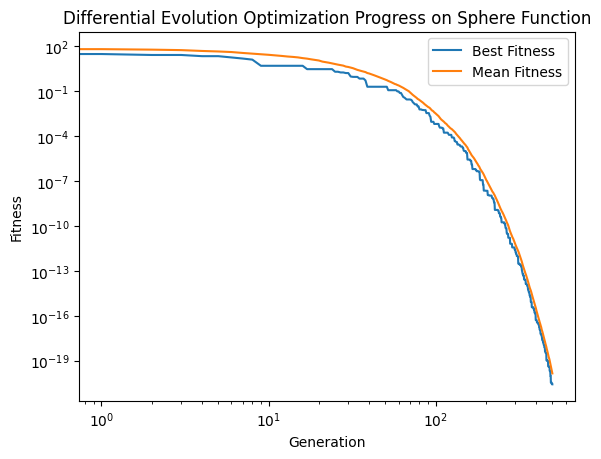

=== RASTRIGIN FUNCTION ===
Best solution found: tensor([-0.0716, -1.0334, -0.9988, -0.0394, -0.9712,  0.0850, -0.9896,  2.0565,
         1.0242,  1.0467], device='cuda:0')
Best solution fitness: tensor(14.6363, device='cuda:0')



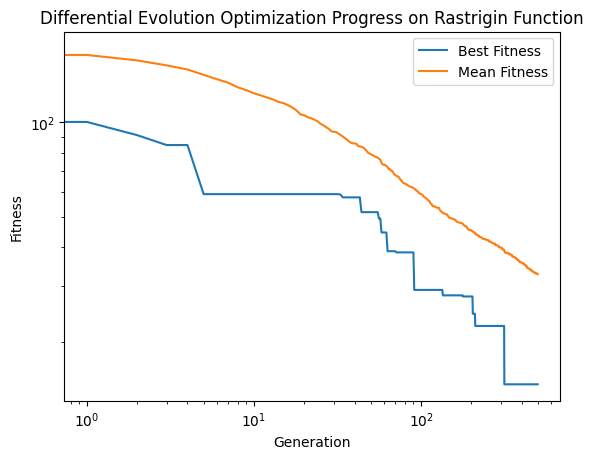

=== ROSENBROCK FUNCTION ===
Best solution found: tensor([ 0.9818,  0.9655,  0.9238,  0.8496,  0.7396,  0.5534,  0.3160,  0.1052,
         0.0151, -0.0017], device='cuda:0')
Best solution fitness: tensor(2.5948, device='cuda:0')



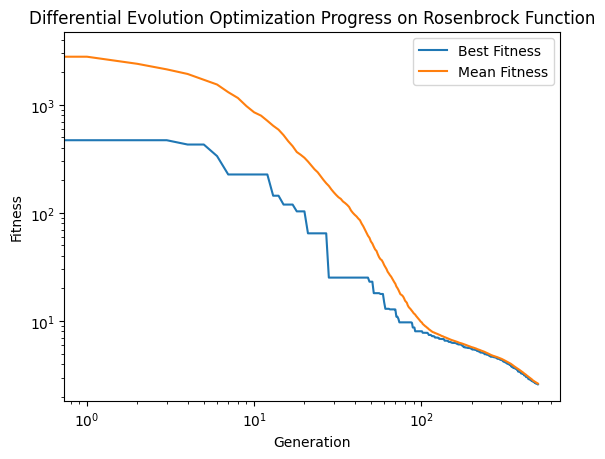

=== ACKLEY FUNCTION ===
Best solution found: tensor([ 4.6218e-07, -8.4529e-07, -2.6039e-07, -4.0242e-07, -1.4999e-07,
         1.5959e-06, -2.1621e-07, -7.8966e-07,  3.1819e-08, -8.9920e-07],
       device='cuda:0')
Best solution fitness: tensor(9.5367e-07, device='cuda:0')



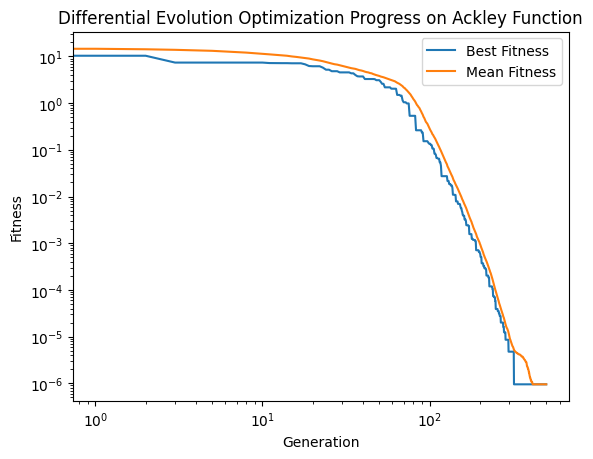

=== SCHWEFEL FUNCTION ===
Best solution found: tensor([ 418.0538,  416.8405,  180.7603,  420.1563,  419.0321,  393.5382,
         413.4064,  413.6713,  431.8960, -310.5892], device='cuda:0')
Best solution fitness: tensor(529.5513, device='cuda:0')



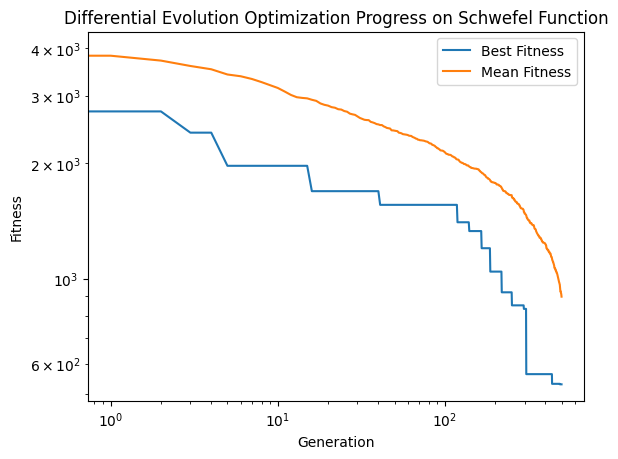

=== GRIEWANK FUNCTION ===
Best solution found: tensor([ 3.2314, -4.8107, -0.1854, -0.4725, -7.0950,  7.9067,  0.3377, -0.4076,
         0.1104,  0.5366], device='cuda:0')
Best solution fitness: tensor(0.1411, device='cuda:0')



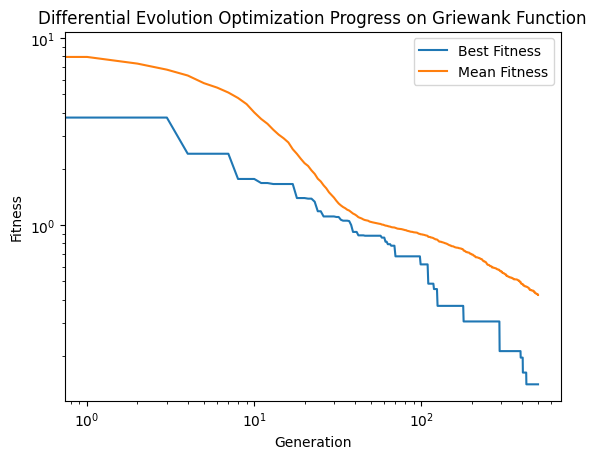

=== LEVY FUNCTION ===
Best solution found: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')
Best solution fitness: tensor(7.6427e-15, device='cuda:0')



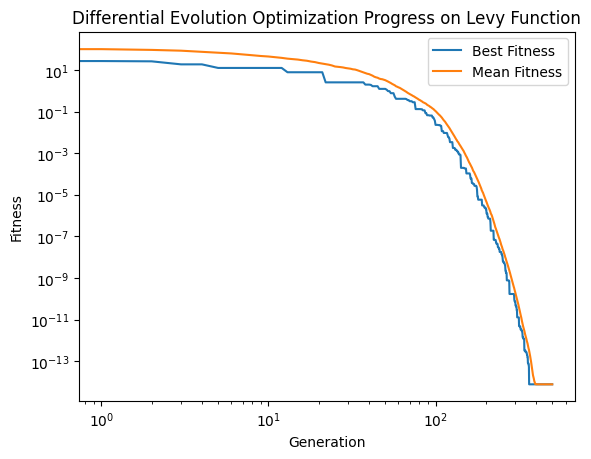

In [4]:
import matplotlib.pyplot as plt


for name, obj in objective_functions.items():
    solution = obj["solution"]
    best_solution, best_fitness, fitness_history = solution["best_solution"], solution["best_fitness"], solution["fitness_history"]
    best_fitness_history = fitness_history["best"]
    mean_fitness_history = fitness_history["mean"]

    print(f"=== {name.upper()} FUNCTION ===")
    print("Best solution found:", best_solution)
    print("Best solution fitness:", best_fitness)
    print()

    plt.plot(best_fitness_history, label="Best Fitness")
    plt.plot(mean_fitness_history, label="Mean Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(f"Differential Evolution Optimization Progress on {name.capitalize()} Function")
    plt.legend()
    plt.show()

# Very good! Now running this on the COCO benchmark

In [ ]:
from cocoex import Problem
import numpy as np
from typing import Optional


def de_coco_wrapper(
        problem: Problem,
        x0: Optional[np.ndarray] = None,
        *,
        budget_multiplier: int = 10,
        **kwargs
    ) -> np.ndarray:
    """Wrapper to run DE on a COCO problem."""
    dim = problem.dimension
    lower, upper = problem.lower_bounds, problem.upper_bounds
    budget = int(budget_multiplier * dim)

    def objective(x_torch: torch.Tensor) -> torch.Tensor:
        """
        Define a PyTorch-compatible callable that delegates evaluation to COCO
        Convert tensor -> numpy -> evaluate -> convert back to tensor
        """
        x_np = x_torch.detach().cpu().numpy()
        fx = []
        for i in range(x_np.shape[0]):
            fx.append(problem(x_np[i]))
        fx = torch.tensor(fx, dtype=torch.float32, device=device)
        print(f"{fx=}")
        return fx

    result = differential_evolution(
        problem=objective,
        n_population=kwargs.get("n_population", 20),
        F=kwargs.get("F", 0.5),
        CR=kwargs.get("CR", 0.7),
        dim=dim,
        search_boundary=(float(lower[0]), float(upper[0])),
        n_generations=max(1, budget // 20),  # simple budget scaling
        initial_solution=torch.tensor(x0, dtype=torch.float32, device=device) if x0 is not None else None,
        maximize=kwargs.get("maximize", False)
    )

    # Return the best solution as a NumPy array
    return result["best_solution"].detach().cpu().numpy()

In [ ]:
from cocoex import Observer, Suite, ExperimentRepeater
from cocoex.utilities import MiniPrint
from cocopp import main


suite_name = "bbob"
budget_multiplier = 1

suite = Suite(suite_name, "", "")
output_folder = f'differential_evolution_{int(budget_multiplier)}D_on_{suite_name}'
observer = Observer(suite_name, "result_folder: " + output_folder)
repeater = ExperimentRepeater(budget_multiplier)
minimal_print = MiniPrint()

while not repeater.done():
    for problem in suite:
        if repeater.done(problem):
            continue
        problem.observe_with(observer)
        problem(problem.dimension * [0])
        xopt = de_coco_wrapper(problem, repeater.initial_solution_proposal(problem), disp=False)
        problem(xopt)
        repeater.track(problem)
        minimal_print(problem)

### post-process data
main(observer.result_folder + ' randomsearch! bfgs!')

COCO INFO: Results will be output to folder exdata/differential_evolution_1D_on_bbob-0007
fx=tensor([81.0916, 80.9753, 80.9051, 80.9599, 81.0127, 81.0658, 80.9065, 80.8686,
        80.9165, 80.9600, 81.0577, 81.0146, 81.0258, 80.8680, 80.8614, 81.0356,
        81.0534, 80.9629, 80.8980, 81.0550], device='cuda:0')


DE Progress:   0%|          | 0/1 [00:00<?, ?it/s]

fx=tensor([81.0145, 80.9556, 81.0159, 81.0737, 81.0730, 81.0315, 80.8499, 80.9434,
        81.0799, 80.8924, 80.8095, 81.0366, 80.8697, 80.9876, 80.9376, 80.8366,
        81.1142, 81.0094, 80.9470, 81.0522], device='cuda:0')
2D 14h59:51
 f1.
Sweep 1 done (0 successes on 1 problem where 0 had >= 1 success and 0 had >= 11 successes and 1 exhausted the budget)
Post-processing (2+)
  Using 3 data sets:
    exdata/differential_evolution_1D_on_bbob-0007
    /home/mslima/.cache/cocopp/das/da/bbob/2009/RANDOMSEARCH_auger_noiseless.tgz
    /home/mslima/.cache/cocopp/das/da/bbob/2009/BFGS_ros_noiseless.tgz

Post-processing (2+)
  loading data...
  using: exdata/differential_evolution_1D_on_bbob-0007
  using: /home/mslima/.cache/cocopp/das/da/bbob/2009/RANDOMSEARCH_auger_noiseless.tgz
  using: /home/mslima/.cache/cocopp/das/da/bbob/2009/BFGS_ros_noiseless.tgz
  Will generate output data in folder ppdata/diffe_RANDO_BFGS_102814h5951
    this might take several minutes.


KeyError: 'exdata/differential_evolution_1D_on_bbob-0007'